## Baseline Performance Test

In [230]:
import time
import statistics

def bench(func, args, repeat=10):
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        func(*args)
        times.append(time.perf_counter() - start)
    return statistics.mean(times)

In [231]:
from nearorder.math.generate import base_sequence

seq = base_sequence(100000)
# seq

## Performance vs. In-Sequence Swaps

,disorder,inversion_count,inversion_ratio,local_inversion_ratio,max_monotonic_run,displacement_sum
0,0,0,0.000000e+00,0.000000,100000,0
1,5000,4786,9.572096e-07,0.045550,206,9566
2,10000,9124,1.824818e-06,0.083041,93,18210
3,15000,13208,2.641626e-06,0.115121,65,26250
4,20000,16974,3.394834e-06,0.141711,48,33596
5,25000,20398,4.079641e-06,0.163052,47,40258
6,30000,23750,4.750048e-06,0.183552,45,46528
7,35000,26682,5.336453e-06,0.199842,50,52048
8,40000,29648,5.929659e-06,0.213142,33,57498
9,45000,32376,6.475265e-06,0.225962,27,62518


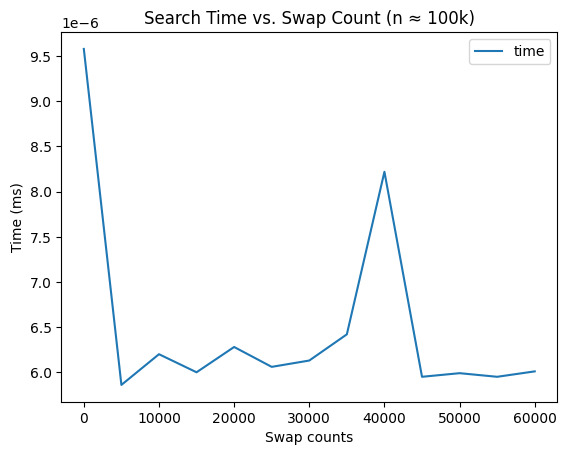

In [283]:
from nearorder.math.generate import inject_adjacent_swaps
from nearorder.math.metrics import disorder_metrics
from nearorder.bisect import binary_search

import random
import pandas as pd

num = random.randint(1, 100000)

def test_find_num(xs):
    binary_search(xs, num)

time_rows = []
disorder_rows = []

for disorder in [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000]:
    target = inject_adjacent_swaps(xs=seq, swaps=disorder)
    t = bench(test_find_num, args=[target])
    time_rows.append({"disorder": disorder, "time": t})
    metrics = disorder_metrics(target)
    metrics.pop('n')
    disorder_rows.append({"disorder": disorder} | metrics)

df1 = pd.DataFrame(time_rows)
ax = df1.plot(x="disorder")
ax.set_xlabel("Swap counts")
ax.set_ylabel("Time (ms)")
ax.set_title("Search Time vs. Swap Count (n ≈ 100k)")

df2 = pd.DataFrame(disorder_rows)
df2

At the 100k scale, varying the swap count between 10,000 and 60,000 results in little difference in search performance.